In [5]:
# from ocetrac.model import Tracker

# import pytest
import xarray as xr
import numpy as np
import scipy.ndimage
from skimage.measure import regionprops
from skimage.measure import label as label_np
import dask.array as dsa
from xarray.tests import raise_if_dask_computes
import matplotlib.pyplot as plt

%matplotlib inline

ModuleNotFoundError: No module named 'pytest'

In [2]:
def example_data():

    x = np.arange(-10,11,1)
    y = np.arange(-10,11,1)
    xdim = 'x'; ydim = 'y'
    da = xr.DataArray(np.zeros((5,21,21)),
                     dims=["time", ydim, xdim],
                     coords={"time": np.arange(1,6), ydim: y, xdim: x},
                    )
    da[0, 2:6, 2:9] = 1
    da[0, 12:18, -6:-2] = 1

    for i in enumerate(da.time[:-1].values):
        da[i[1],:,:] = da.isel(time=i[0]).roll(x=2, roll_coords=False)

    mask = xr.DataArray(np.ones(da.isel(time=0).shape),
                    dims=[ydim, xdim],
                    coords={ydim: y, xdim: x}
                   )
    mask[11:14,:3] = 0
    mask[:4,5:6] = 0

    return da, mask

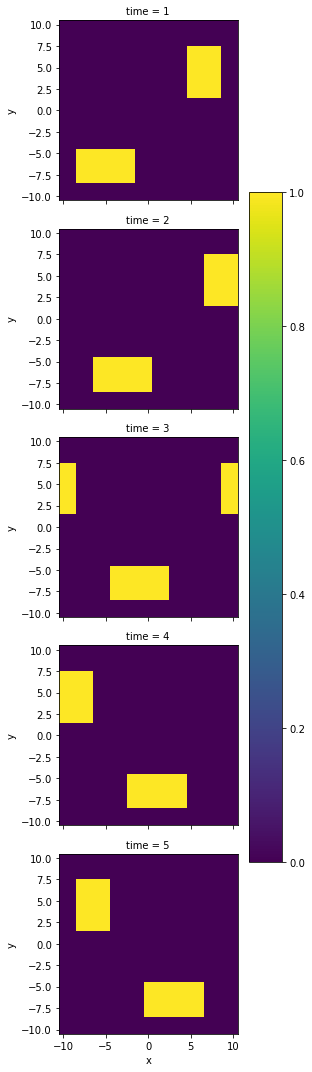

In [3]:
da, mask = example_data()
da.plot(x="x", y="y", col="time", col_wrap=1)

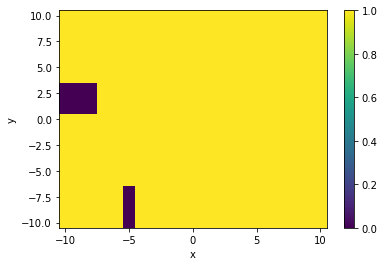

In [4]:
mask.plot()

In [ ]:
def test_track(da, mask, radius, min_size_quartile, xdim, ydim, dask):

#     da, mask = example_data
#     da = da.rename({'lon':xdim, 'lat':ydim})
#     mask = mask.rename({'lon':xdim, 'lat':ydim})
    if dask:
        da = da.chunk({'time':1})

    tracker = Tracker(da, mask, radius, min_size_quartile, xdim=xdim, ydim=ydim)
    new_labels = tracker.track()

#     assert (
#         new_labels.attrs["percent area reject"]
#         + new_labels.attrs["percent area accept"]
#     ) == 1.0

In [5]:
radius = 2
min_size_quartile = 0
xdim = 'x'
ydim = 'y'
timedim = 'time'
dask = True
da_chunked = da.chunk({'time':1})
# mask_chunked = mask.chunk({xdim:-1, ydim:-1})
mask_chunked = mask 

tracker_dask = Tracker(da_chunked, mask_chunked, radius, min_size_quartile, xdim=xdim, ydim=ydim)
labels_dask = tracker_dask.track()

RuntimeError: Too many computes. Total: 1 > max: 0.

In [ ]:
def test_track_dask_lazy(da, mask, radius=2, min_size_quartile=0.75, xdim='x', ydim='y'):
    # Check that dask computation is lazy and results are the same for eager/lazy compute

    da_chunked = da.chunk({'time':1})
    # mask_chunked = mask.chunk({xdim:-1, ydim:-1})
    mask_chunked = mask # dont chunk for now to not trigger the error in `self.mask == 0).all():`

    tracker = Tracker(da, mask, radius, min_size_quartile, xdim=xdim, ydim=ydim)
    labels = tracker.track()

    with raise_if_dask_computes(): #temporarily deactivated
        tracker_dask = Tracker(da_chunked, mask_chunked, radius, min_size_quartile, xdim=xdim, ydim=ydim)
        labels_dask = tracker_dask.track()

    xr.testing.assert_allclose(labels, labels_dask)

## Without Dask

In [ ]:
tracker = Tracker(da, mask, radius, min_size_quartile, xdim=xdim, ydim=ydim)
labels = tracker.track()

labels.plot(x="x", y="y", col="time", col_wrap=5)

## With Dask

In [ ]:
da_chunked = da.chunk({'time':1})
# mask_chunked = mask.chunk({xdim:-1, ydim:-1})
mask_chunked = mask # dont chunk for now to not trigger the error in `self.mask == 0).all():`

with raise_if_dask_computes():
    tracker_dask = Tracker(da_chunked, mask_chunked, radius, min_size_quartile, xdim=xdim, ydim=ydim)
    labels_dask = tracker_dask.track()

labels_dask.plot(x="x", y="y", col="time", col_wrap=5)

In [ ]:
if (self.mask == 0).all():
    raise ValueError('Found only zeros in `mask` input. The mask should indicate valid regions with values of 1')

# Convert data to binary, define structuring element, and perform morphological closing then opening
binary_images = morphological_operations()

# Apply mask
binary_images_with_mask  = self._apply_mask(binary_images,self.mask) # perhaps change to method? JB

if (binary_images_with_mask == 0).all():
    raise ValueError('No features found in `da` input. Try adjusting `radius` and `min_size_quartile`')

# Filter area
area, min_area, binary_labels, N_initial = self._filter_area(binary_images_with_mask)

# Label objects
labels, num = self._label_either(binary_labels, return_num= True, connectivity=3)

# Wrap labels
labels_wrapped, N_final = self._wrap(labels)

# Final labels to DataArray
new_labels = xr.DataArray(labels_wrapped, dims=self.da.dims, coords=self.da.coords)   
new_labels = new_labels.where(new_labels!=0, drop=False, other=np.nan)


In [ ]:
radius=2
def morphological_operations(self): 
        # Convert images to binary. All positive values == 1, otherwise == 0
        bitmap_binary = da.where(da>0, drop=False, other=0)
        bitmap_binary = bitmap_binary.where(bitmap_binary==0, drop=False, other=1)

        # Define structuring element
        diameter = radius*2
        x = np.arange(-radius, radius+1)
        x, y = np.meshgrid(x, x)
        r = x**2+y**2 
        se = r<radius**2


    def binary_open_close(bitmap_binary):
        with raise_if_dask_computes():
            bitmap_binary_padded = np.pad(bitmap_binary,
                                      ((diameter, diameter), (diameter, diameter)),
                                      mode='wrap')
            s1 = scipy.ndimage.binary_closing(bitmap_binary_padded, se, iterations=1)
            s2 = scipy.ndimage.binary_opening(s1, se, iterations=1)
            unpadded= s2[diameter:-diameter, diameter:-diameter]
        return unpadded

    with raise_if_dask_computes():
        mo_binary = xr.apply_ufunc(binary_open_close, bitmap_binary,
                               input_core_dims=[[ydim, xdim]],
                               output_core_dims=[[ydim, xdim]],
                               output_dtypes=[bitmap_binary.dtype],
                               vectorize=True,
                               dask='parallelized')


In [ ]:
plt.pcolormesh(se)

In [ ]:
mo_binary.isel(time=2).plot()

In [ ]:
with raise_if_dask_computes():

    binary_images = da.where(mask==1, drop=False, other=0)

In [ ]:
def label_either(data, **kwargs):
        with raise_if_dask_computes():
            if isinstance(data, dsa.Array):
                try:
                    from dask_image.ndmeasure import label as label_dask
                    def label_func(a, **kwargs):
                        ids, num = label_dask(a, **kwargs)
                        return ids
                except ImportError:
                    raise ImportError(
                        "Dask_image is required to use this function on Dask arrays. "
                        "Either install dask_image or else call .load() on your data."
                    )
            else:
                label_func = label_np
        return label_func(data, **kwargs)
    
def get_labels(binary_images):
    with raise_if_dask_computes():
        blobs_labels = label_either(binary_images, background=0)
    return blobs_labels

def _wrap(labels):
        ''' Impose periodic boundary and wrap labels'''
        with raise_if_dask_computes():
            first_column = labels[..., 0]
            last_column = labels[..., -1]

            unique_first = np.unique(first_column[first_column>0])

            # This loop iterates over the unique values in the first column, finds the location of those values in 
            # the first columnm and then uses that index to replace the values in the last column with the first column value
            for i in enumerate(unique_first):
                first = np.where(first_column == i[1])
                last = last_column[first[0], first[1]]
                bad_labels = np.unique(last[last>0])
                replace = np.isin(labels, bad_labels)
                labels[replace] = i[1]

            labels_wrapped = np.unique(labels, return_inverse=True)[1].reshape(labels.shape)

            # recalculate the total number of labels 
            N = np.max(labels_wrapped)

        return labels_wrapped, N
    
with raise_if_dask_computes():
    
    labels = xr.apply_ufunc(get_labels, binary_images,
                            input_core_dims=[[ydim, xdim]],
                            output_core_dims=[[ydim, xdim]],
                            output_dtypes=[binary_images.dtype],
                            vectorize=True,
                            dask='parallelized')

    labels = labels.where(labels>0, drop=False, other=np.nan)  

#         # The labels are repeated each time step, therefore we relabel them to be consecutive
#         # for i in range(1, labels.shape[0]):
#         #     labels[i,:,:] = labels[i,:,:].values + labels[i-1,:,:].max().values
#         # dask friendly version
#             # the dask friendly (and label aware version)
    timedim = 'time' # should be an input
    max_dims = [di for di in labels.dims if di!=timedim]
    first_slice = labels.isel({timedim:0})
    remaining_slice = labels.isel({timedim:slice(1,None)})
    shifted_slice = labels.max(max_dims).isel({timedim:slice(0,-1)}) # effectively shifted `remaining slice` one element back in time
#         # now just replace the time coordinate, so we avoid xarrays alignment
    shifted_slice = shifted_slice.assign_coords({timedim:remaining_slice[timedim]})
    max_padded_values = remaining_slice + shifted_slice

    labels = labels.where(labels>0, drop=False, other=0)  
    labels_wrapped, N_initial = _wrap(np.array(labels))

#         # Calculate Area of each object and keep objects larger than threshold
    props = regionprops(labels_wrapped.astype('int'))
    labelprops = [p.label for p in props]
    labelprops = xr.DataArray(labelprops, dims=['label'], coords={'label': labelprops}) 
    area = xr.DataArray([p.area for p in props], dims=['label'], coords={'label': labelprops})  # Number of pixels of the region.
    min_area = np.percentile(area, min_size_quartile*100)
    print('minimum area: ', min_area) 
    keep_labels = labelprops.where(area>=min_area, drop=True)
    keep_where = np.isin(labels_wrapped, keep_labels)
    out_labels = xr.DataArray(np.where(keep_where==False, 0, labels_wrapped), dims=binary_images.dims, coords=binary_images.coords)

#         # Convert images to binary. All positive values == 1, otherwise == 0
    binary_labels = out_labels.where(out_labels==0, drop=False, other=1)

#         return area, min_area, binary_labels, N_initial

In [ ]:
out_labels.isel(time=4).plot()

In [18]:
def example_data():

    x0 = [180, 225, 360, 80, 1, 360, 1]
    y0 = [0, 20, -50, 40, -50, 40, 40]
    sigma0 = [15, 25, 30, 10, 30, 15, 10]

    lon = np.arange(0, 360) + 0.5
    lat = np.arange(-90, 90) + 0.5
    x, y = np.meshgrid(lon, lat)
    timedim = 'time'; xdim = 'lon'; ydim = 'lat'

    def make_blobs(x0, y0, sigma0):
        blob = np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma0 ** 2))
        return blob

    features = {}
    for i in range(len(x0)):
        features[i] = make_blobs(x0[i], y0[i], sigma0[i])

    first_image = features[0] + features[1] + features[3] - 0.5

    da = xr.DataArray(
        first_image[np.newaxis, :, :],
        dims=[timedim, ydim, xdim],
        coords={timedim: [1], ydim: lat, xdim: lon},
    )

    da_shift_01 = da.shift(lon=0, lat=-20, fill_value=-0.5)
    da_shift_02 = da.shift(lon=0, lat=-40, fill_value=-0.5) + (
        features[2] + features[4] + features[5] + features[6]
    )
    da_shift_03 = da.shift(lon=0, lat=-40, fill_value=-0.5) + (
        features[2] + features[5] + features[6]
    )

    Anom = xr.concat(
        (
            da,
            da_shift_01,
            da_shift_02,
            da_shift_03,
        ),
        dim='time',
    )

    Anom['time'] = np.arange(1, 5)

    mask = xr.DataArray(np.ones(Anom[0, :, :].shape), coords=Anom[0, :, :].coords)
    mask[60:90, 120:190] = 0

    return Anom, mask

In [19]:
Anom, mask = example_data()

In [20]:
da = Anom.expand_dims('level')


In [21]:
da.dims

('level', 'time', 'lat', 'lon')

In [22]:
timedim='time'
ydim = 'lat'
xdim = 'lon'

In [26]:
assert ((timedim, ydim, xdim) != Anom.expand_dims('level').dims)

In [24]:
if ((timedim, ydim, xdim) != Anom.expand_dims('level').dims):
    try:
        da = da.transpose(timedim, ydim, xdim) 
    except:
        raise ValueError(f'Ocetrac currently only supports 3D DataArrays. The dimensions should only contain ({timedim}, {xdim}, and {ydim}). Found {list(da.dims)}')


ValueError: Ocetrac currently only supports 3D DataArrays. The dimensions should only contain (time, lon, and lat). Found ['level', 'time', 'lat', 'lon']